# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        res = []
        for x in X:
            res.append(1 / (1 + np.exp(-np.dot(weights ,x))))
        return np.array(res)
    
    def get_loss(self, X, weights, y):
        sm = []
        for x in X:
            sm.append(np.sum(weights * x) )
        sm = np.array(sm)
        N = len(y)
        res = 1/N * np.sum(np.log(1 + np.exp(-sm*y))) + (1/(2*self.C) ) * np.linalg.norm(weights)**2
        return res
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.loss_hist= []
        for i in range(self.max_iter): 
            delta = np.zeros(num_features) 
            for j in range(len(y)):
                sm = self.weights_ @ X_ext[j]
                delta +=  y[j]*X_ext[j] * (1 - 1/(1 + np.exp(-sm*y[j]))) 
            delta /= len(y)
            delta -= (1/self.C)*self.weights_
            self.weights_ += self.eta * delta
            self.loss_hist.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm( self.eta * delta) < self.tol:
                break
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        res = np.array([1 if pr >= 0.5 else -1 for pr in self.predict_proba(X)])
        return res

In [6]:
from sklearn import datasets
from sklearn import metrics

1437

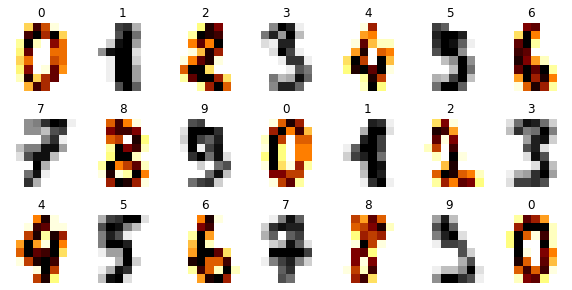

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

len(X_train) 

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [14]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [15]:
model = CustomLogisticRegression()

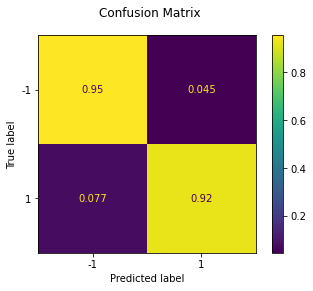

In [16]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [17]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [18]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

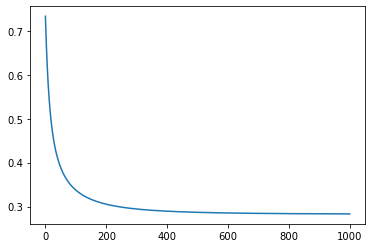

In [19]:
plt.plot(model.loss_hist)

Чем больше итерераций в подборе весов тем меньше значем LOSS, что логично так как цель подбора весов - минимизировать loss функцию

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

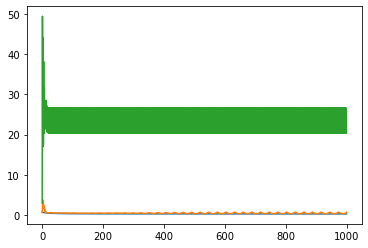

In [20]:
m1 = CustomLogisticRegression(eta=0.001)
m2 = CustomLogisticRegression(eta=0.01)
m3 = CustomLogisticRegression(eta=0.1)
m1.fit(X_train, y_train)
m2.fit(X_train, y_train)
m3.fit(X_train, y_train)
plt.plot(m1.loss_hist)
plt.plot(m2.loss_hist)
plt.plot(m3.loss_hist)

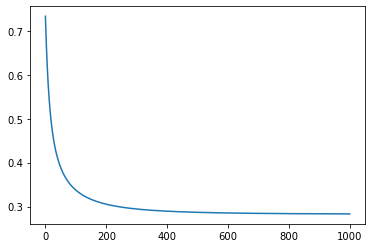

In [21]:
plt.plot(m1.loss_hist)

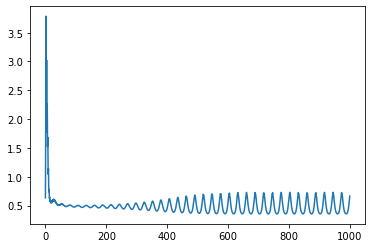

In [22]:
plt.plot(m2.loss_hist)

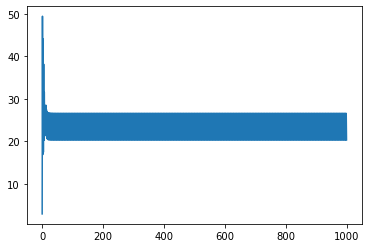

In [23]:
plt.plot(m3.loss_hist)

Чем выше скорость, тем меньше точность. Начиная с некоторого момента loss начинает иметь опреденную амплитуду и не изменяется

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [24]:
## your code

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

In [25]:
m1_zero = CustomLogisticRegression(zero_init=True)
m1_random = CustomLogisticRegression()
m1_zero.fit(X_train, y_train)
m1_random.fit(X_train, y_train)

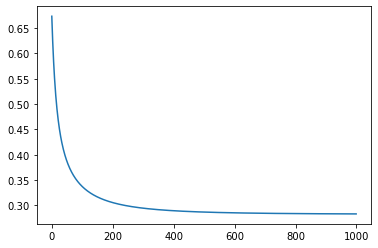

In [26]:
plt.plot(m1_zero.loss_hist)

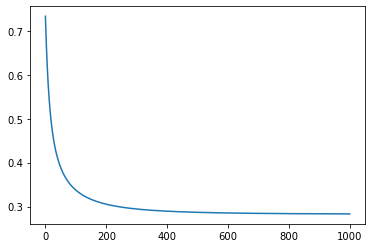

In [27]:
plt.plot(m1_random.loss_hist)

Разница между нулевыми и случайными весами только в изначально точности в данном случае. В случае с случайнми весами точность может меняться в зависимости от случаного распределения весов

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [93]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        par_dist = np.array([np.zeros(len(Y)) for i in range(len(X))])
        for i in range(len(X[0])):
            for j in range(len(Y)):
                par_dist[i][j] = np.linalg.norm(X[i] - Y[j])
                
        return par_dist
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        dct = dict(zip(self.classes_, np.zeros(len(self.classes_))))
        for i in range(len(y)):
            dct[y[i]] += weights[i]
        
        return np.array(list(dct.values())).astype(int)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                a =1 
                #weights_of_points = [self.get_class_weights(y, P[i]) for i in range(len(P))]
                
            # тут я не разобралась как именно нужно реализовавыть эту функцию поэтому вставлен метод и библиотеки    
            knn_cheat = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights)
            knn_cheat.fit(self.points, list(map(str, self.y)))
            return knn_cheat.predict_proba(X)
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        pr = [list(x).index(1) for x in self.predict_proba(X)]
        
        return pr

In [94]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [95]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [96]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

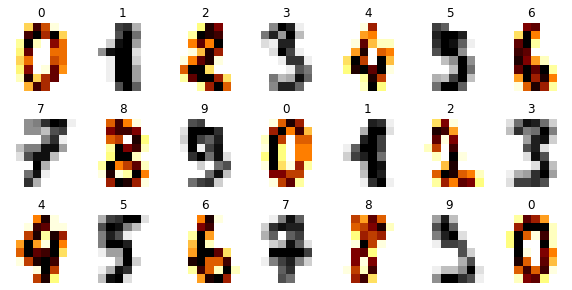

In [97]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [98]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [99]:
len(model.predict_proba(X_test))

360

In [100]:
model.y.shape

(1437,)

In [101]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [102]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [104]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

ValueError: 1 is not in list

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [117]:
PATH = "./data/"

In [118]:
data = pd.read_csv(os.path.join('train.csv')).set_index('PassengerId')

In [119]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

<AxesSubplot:title={'center':'Men and women count'}, xlabel='Sex', ylabel='Values amount'>

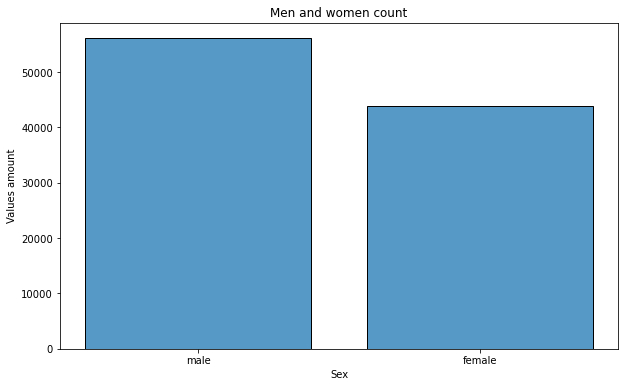

In [120]:
plt.figure(figsize=(10,6))

plt.title("Men and women count")

plt.ylabel("Values amount")

sns.histplot(data=data.Sex, shrink=.8)

<AxesSubplot:title={'center':'Survived'}, ylabel='Values amount'>

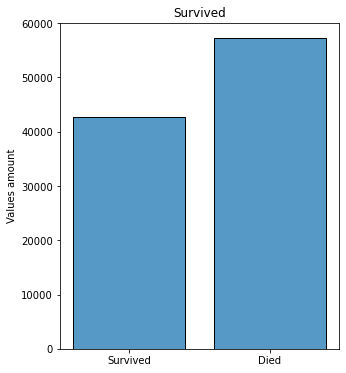

In [121]:
def surv(row):
    if row.Survived == 1:
        return 'Survived'
    else:
        return 'Died'
plt.figure(figsize=(5,6))

plt.title("Survived")

plt.ylabel("Values amount")
sns.histplot(data=data.apply(surv, axis=1), shrink=.8)

<AxesSubplot:title={'center':'Men and women survived'}, xlabel='Sex', ylabel='Values amount'>

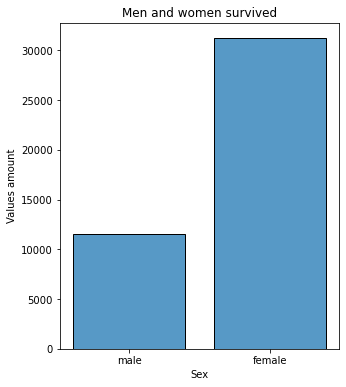

In [122]:
plt.figure(figsize=(5,6))

plt.title("Men and women survived")

plt.ylabel("Values amount")

sns.histplot(data=data[data.Survived == 1].Sex, shrink=.8)

Женщин выжило в три раза больше чем мужчин, при условии, что всего мужчин на 10000 больше, чем женщин

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:title={'center':'Age'}, xlabel='Age', ylabel='Values amount'>

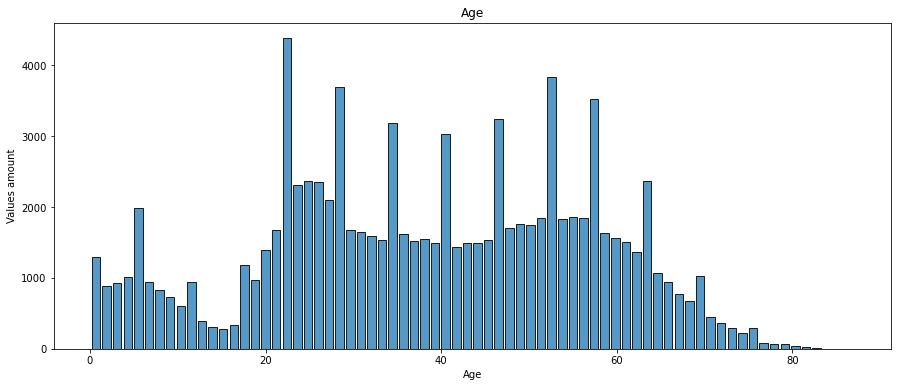

In [123]:
plt.figure(figsize=(15,6))

plt.title("Age")

plt.ylabel("Values amount")

sns.histplot(data=data.Age, shrink=.8)

<AxesSubplot:title={'center':'Survivid and died per age'}, xlabel='Age', ylabel='Values amount'>

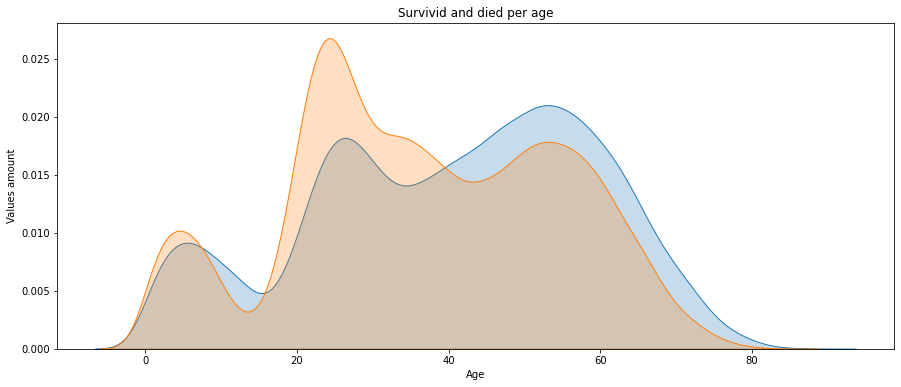

In [124]:
plt.figure(figsize=(15,6))

plt.title("Survivid and died per age")

plt.ylabel("Values amount")

sns.kdeplot(data=data[data.Survived == 1].Age, label="Survived", shade=True)
sns.kdeplot(data=data[data.Survived == 0].Age, label="Died", shade=True)

In [125]:
data[data.Survived == 1].Age.describe()

count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

In [126]:
data[data.Survived == 0].Age.describe()

count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64

Из графика распределений можно сделать вывод, что возраст существенно влияет на выживаемость только в отрезке от 20-30 - в этом промежутке значительно больше погибших

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:title={'center':'Passenger classes'}, xlabel='Pclass', ylabel='Values amount'>

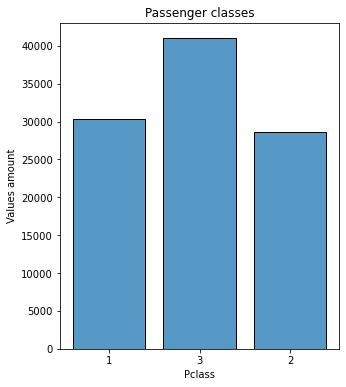

In [128]:
plt.figure(figsize=(5,6))

plt.title("Passenger classes")

plt.ylabel("Values amount")
sns.histplot(data = data.Pclass.astype(str), shrink=0.8)

<AxesSubplot:title={'center':'Survives per classes'}, xlabel='Pclass', ylabel='Values amount'>

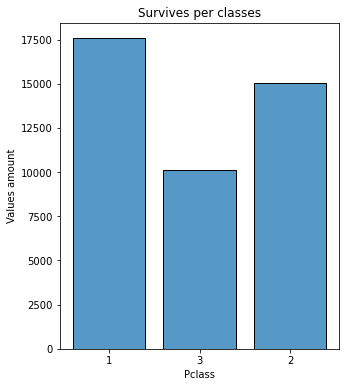

In [130]:
plt.figure(figsize=(5,6))

plt.title("Survives per classes")

plt.ylabel("Values amount")

sns.histplot(data = data[data.Survived == 1].Pclass.astype(str), shrink=0.8)

<AxesSubplot:title={'center':'Port of Embarkation'}, xlabel='Embarked', ylabel='Values amount'>

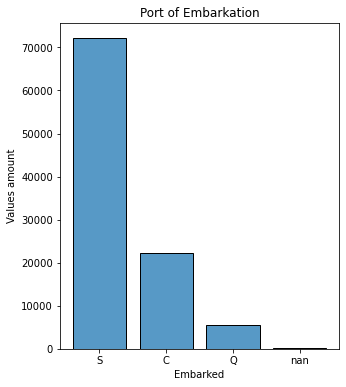

In [131]:
plt.figure(figsize=(5,6))

plt.title("Port of Embarkation")

plt.ylabel("Values amount")

sns.histplot(data = data.Embarked.astype(str), shrink=0.8)

<AxesSubplot:title={'center':'Survived per port of Embarkation'}, xlabel='Embarked', ylabel='Values amount'>

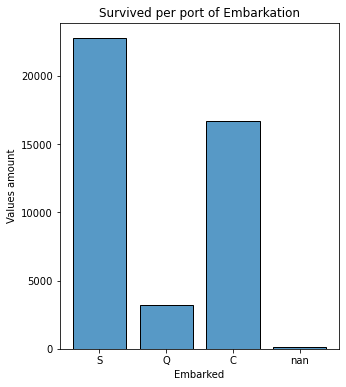

In [135]:
plt.figure(figsize=(5,6))

plt.title("Survived per port of Embarkation")

plt.ylabel("Values amount")

sns.histplot(data = data[data.Survived == 1].Embarked.astype(str), shrink=0.8)

Больше всего выжило пассажиров 1 класса, меньше все - из 3. При этом 3 класс самый многочисленный. 2 класс по численности почти не уступает 1, при этом во 2 выжило значительно меньше пассжиров. Таким образом, самым безопасным классом является 1

Интересная зависимость выживания в зависимости от порта посадки - в процентном соотношении людей из порта С выжило намного больше, чем из остальных

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [136]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'feature': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,feature,percent_missing
Survived,Survived,0.000
Pclass,Pclass,0.000
Name,Name,0.000
Sex,Sex,0.000
Age,Age,3.292
SibSp,SibSp,0.000
Parch,Parch,0.000
Ticket,Ticket,4.623
Fare,Fare,0.134
Cabin,Cabin,67.866


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Недостаищюе метрики возраста можно заменить немколькими способами: подставить меиданное значение, среднее значение или подставлять рандомные значения из множества значений (с некоторым заданным распределением)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.